# Project 4: Sequential Structure from Motion

### Due 4/3/2019

### Graduate Students: Our next reading is [Snavely, 2006](http://195.130.87.21:8080/dspace/bitstream/123456789/636/1/Photo%20tourism%20exploring%20photo%20collections%20in%203D.pdf).  We'll have a written report on this one: these methods papers aren't as good for discussions as I'd hoped.

## Problem Statement

You have now developed code that takes two photographs, finds matching locations in both, determines the relative motion between the cameras that took both photos, and solves for the 3D position of those points using epipolar geometry.  **The next (and final for our purposes) stage is to extend this analysis to more than two images**, such that we can build 3D models of objects on the ground with just about as much detail as we'd like.

## Adding the third photo
How do we add these additional photos?  To be perfectly honest, at this point it's mostly an exercise in match housekeeping: we've already developed most of the code that we need.  First, let's consider what we've got after matching our first two images, $I_1$ and $I_2$.  First, we have a set of keypoints in each image, associated with a set of matches.  These matches have been quality controlled twice:  first by the ratio test, then by RANSAC in conjunction with the recovery of the essential matrix.  Assuming that we've used our known camera matrix to convert our pixel-wise coordinates to generalized coordinates, let's call these keypoints $\mathbf{x}_1$ and $\mathbf{x}_2$.  In practice, we can drop all of those keypoints for which there is not an associated accepted match.  Then, for each of our kept matches, we have the essential matrix $E_{12}$, from which we can extract a pair of projection matrices $\mathbf{P}_1 = [\mathbf{I}|\mathbf{0}]$ and $\mathbf{P}_2 = [\mathbf{R}_2|\mathbf{t}_2]$.  Using these projection matrices, we generated 3D, world coordinate location of the corresponding features that showed up robustly in both images.  We'll call these coordinates $\mathbf{X}_{12}$.  

To add a third image $\mathbf{I}_3$ to the mix, consider that the situation outlined above is sort of analogous to the information that we have when we want to do pose estimation with ground control points: we have 3D world coordinates as well as the image coordinates of a set of points (a bunch of them, usually!), and we want to recover the camera pose.  The problem is that the feature generalized coordinates that we've computed are for $I_1$ and $I_2$, but not $I_3$.  Is this a big problem?  Of course not!  We can simply find $\mathbf{x}_3$ in $I_3$ that correspond to $\mathbf{x}_2$, the keypoints in the second image.  Then we identify these keypoints with the 3D poi nts $\mathbf{X}_{12}$.  Thus we have image coordinates of features in the third image and the corresponding world coordinates: we can now perform pose estimation, just as we did in Project 1.  

Of course there are a few minor caveats: first, we need to filter out spurious matches between $\mathbf{x}_2$ and $\mathbf{x}_3$.  To do this, we can utilize a tool that we already have: RANSAC estimation of the essential matrix.  Because $I_2$ and $I_3$ are related by epipolar geometry just as $I_1$ and $I_2$ are, we can use the same subroutine to compute the essential matrix $\mathbf{E}_{23}$, and (critically) identify and filter outliers, i.e. we'll discard matches that don't don't correspond to the consensus view of the essential matrix.  This also leads to the next caveat, namely that we need an initial guess (call it $P_3^0$) for pose estimation to converge properly.  Where should this initial guess come from?  The $\mathbf{E}_{23}$ provides a rotation given as if camera 2 were canonical, i.e. $\mathbf{P_2'}=[\mathbf{I}|\mathbf{0}]$, $\mathbf{P_3}'=[\mathbf{R}_3'|\mathbf{t}_3']$.  We'll call it $P_3'$.  We need to convert this projection matrix to a coordinate system in which $I_1$ (not $I_2$) is canonical.  Fortunately, this is easy:
$$
P_3 \approx P_2 P_3'.
$$
This $P_3$, is a an excellent initial guess for pose estimation (in principle, it's rotation matrix should actually be correct).  Note that the translation component is only good up to a constant: however, this isn't too problematic because its direction is close to correct, and any optimization just needs to perform what amounts to a line search (a univariate optimization problem) to find the correct scaling. 

Once we have a robust estimation of the third camera's pose, we can use it do point triangulation on the correspondences between $I_2$ and $I_3$ not associated with an already-known world coordinate point, which allows us to augment our 3D model with new points.  Additionally, we can perform triangulation with *3 views*, potentially improving our accuracy.  Moreover, we can apply the process above iteratively, adding more and more images to generate a highly featured 3D model from (for example) 360 degrees worth of view angles.  

## Application
**Generate code that performs the above process for a third image.  Apply it to one of the 3D image datasets that we generated in class.  Note that we will be collecting aerial imagery from drones as well.  Apply this method to a sequence of drone imagery as well.**  As a challenge, can you implement code that sequentially adds an arbitrary number of images?


In [5]:
%matplotlib notebook
import pointgen
import importlib
importlib.reload(pointgen)
pg = pointgen

class cloud_generator:
    def __init__(self, ifnames, imgs):
        self.ifnames = ifnames
        self.imgs = imgs
        self.point_cloud = None

    def generate(self):
        self.point_cloud = pg.get_pt_cloud(self.ifnames, self.imgs)

In [7]:
import matplotlib.pyplot as plt

ifnames = [
    "falcon01.jpg",
    "falcon02.jpg",
    "falcon03.jpg",
    "falcon04.jpg",
    "falcon05.jpg",
    "falcon06.jpg",
    "falcon07.jpg",
    "falcon08.jpg",
]
imgs = [plt.imread(f) for f in ifnames]

Common Keypoints: 200
Estimate:
[[ 0.4218987  -0.74015321  0.52361695 -1.79752032]
 [ 0.73765354  0.61601151  0.2764002  -0.6788313 ]
 [-0.52713257  0.26963501  0.80587109  0.45708198]]
Optimized:
[[ 0.41761609 -0.74185307  0.52464351 -1.4500891 ]
 [ 0.74172162  0.61184942  0.27475321 -0.74756505]
 [-0.52482934  0.27439808  0.80576663  0.51620814]]


<IPython.core.display.Javascript object>


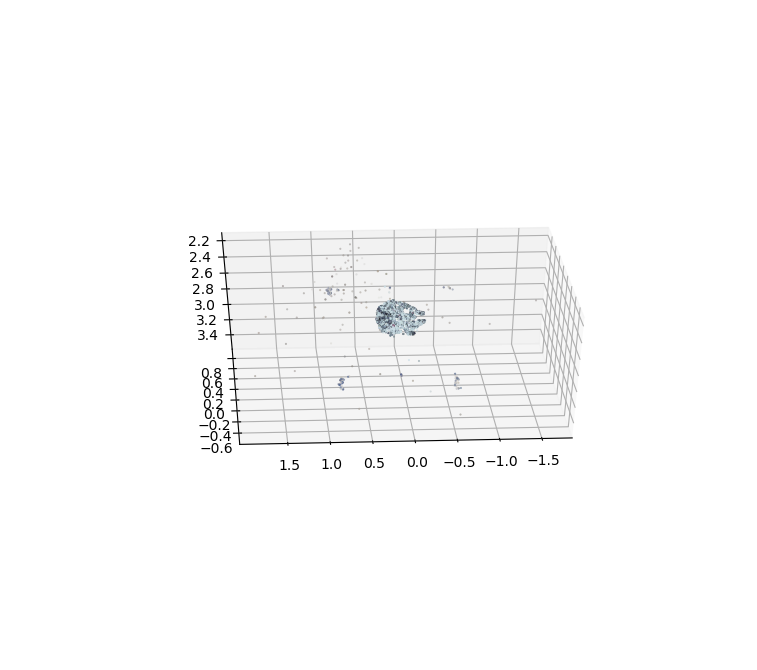

In [9]:
# Create a generator object, and generate point cloud
myGenerator = cloud_generator(ifnames, imgs)
myGenerator.generate()
pg.plot_pcd(myGenerator.point_cloud, s=1)